# Point Pattern Density
- Describe overall point density
- Characterize point spread:
  * random?
  * dispersed?
  * clustered?

## Read in data files

In [2]:
library('spatstat')
library('dplyr')
locale = Sys.setlocale('LC_ALL','C') 
# Load data and metadata
setwd(paste0('/home/micha/Studies/Courses',
             '/Geostatistics-Tal/Final Project/Point pattern statistics/'))
data_cols <- c('station_id','date_time','relialbility',
               'rain_bool','obs_precip','novalue','eor')
gauge_data <- read.csv('gauge_data.csv', col.names=data_cols)
meta_cols <- c('station_id','height','latitude','longitude',
               'from_date','stn_name','province')
gauge_metadata <- read.csv('gauge_metadata.csv', col.names=meta_cols)

In [3]:
head(gauge_data)
head(gauge_metadata)

station_id,date_time,relialbility,rain_bool,obs_precip,novalue,eor
158,2016110101,3,0,0,-999,eor
158,2016110102,3,0,0,-999,eor
158,2016110103,3,0,0,-999,eor
158,2016110104,3,0,0,-999,eor
158,2016110105,3,0,0,-999,eor
158,2016110106,3,0,0,-999,eor


station_id,height,latitude,longitude,from_date,stn_name,province
158,210,50.7840,8.9545,20000701,Amneburg-Rdigheim,
161,75,50.4237,7.4202,20110712,Andernach,
211,200,50.5800,8.4685,20000101,AlarKlein-Altenstdten,
389,436,51.0148,8.4318,20090603,Berleburg,Bad-Arfeld
390,610,50.9837,8.3683,19861126,Berleburg,Bad-Stnzel
535,417,50.0372,7.3079,20040601,Blankenrath,


## Merge gauge locations and data
## Filter for one hour

In [4]:
# Get one hour, and attach metadata
gauge_data_2016110703 <- filter(gauge_data, date_time=='2016110703')
#head(gauge_data_2016110703)
gauges <- merge(gauge_data_2016110703, gauge_metadata, by='station_id', all.y=TRUE)
gauges <- na.omit(gauges)
head(gauges)

station_id,date_time,relialbility,rain_bool,obs_precip,novalue,eor,height,latitude,longitude,from_date,stn_name,province
158,2016110703,3,1,0.3,-999,eor,210,50.7840,8.9545,20000701,Amneburg-Rdigheim,
161,2016110703,3,1,0.0,-999,eor,75,50.4237,7.4202,20110712,Andernach,
211,2016110703,3,1,3.7,-999,eor,200,50.5800,8.4685,20000101,AlarKlein-Altenstdten,
389,2016110703,3,1,0.0,-999,eor,436,51.0148,8.4318,20090603,Berleburg,Bad-Arfeld
390,2016110703,3,1,0.0,-999,eor,610,50.9837,8.3683,19861126,Berleburg,Bad-Stnzel
535,2016110703,3,0,0.0,-999,eor,417,50.0372,7.3079,20040601,Blankenrath,


## Convert to R point pattern

In [5]:
# Convert to ppp
gauges_owin <- ripras(gauges$longitude, gauges$latitude,
                      shape="rectangle")
gauges_marks <- gauges$obs_precip
gauges_ppp <- ppp(gauges$longitude, gauges$latitude, 
                  window=gauges_owin,
                  marks=gauges_marks)
# str(gauges_ppp)
# class(gauges_ppp)
# Check overall intensity
print(summary(gauges_ppp)$intensity)

[1] 24.70659


** units are degrees, ~ 25 gauges per "Square Degree" **

## Overall quadrat count

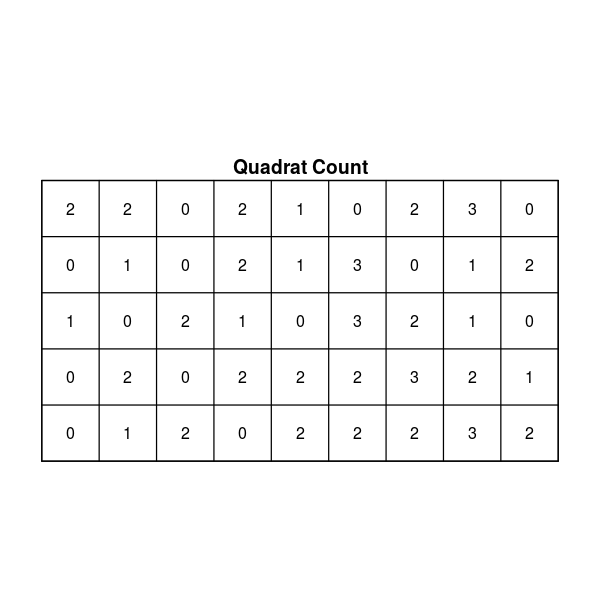

In [6]:
library(repr)
options(repr.plot.width=5, repr.plot.height=5)
opar <- par(cex=0.8, mar=c(1,1,2,1)+0.1)

plot(quadratcount(gauges_ppp, nx=9, ny=5), main="Quadrat Count")

## Gaussian kernel density

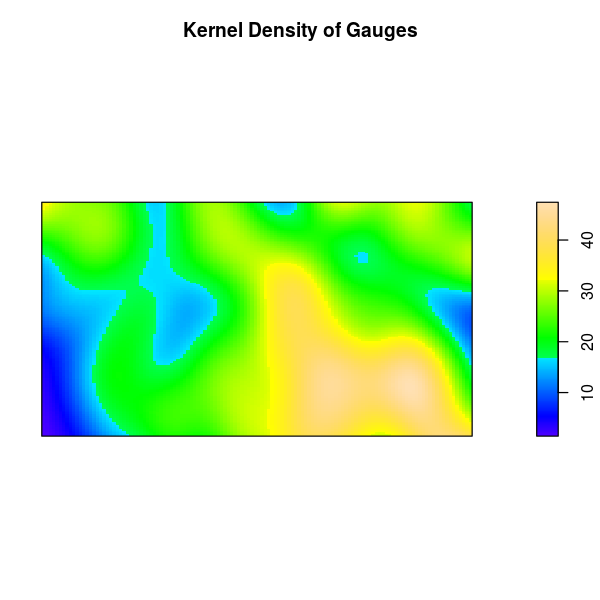

In [7]:
# Get point density and do Kolmogorov-Smirnov
gauges_dens <- density(gauges_ppp)
par(cex=0.8, mar=c(1,1,3,1)+0.1)
plot(gauges_dens, main='Kernel Density of Gauges')

# Check for CSR against poisson distribution
## Kolmogorov-Smirnov

In [8]:
gauges_ks <- kstest(gauges_ppp, gauges_dens)
print(gauges_ks$p.value)

Warning message in kstest.ppp(gauges_ppp, gauges_dens):
"marks ignored"

[1] 1.058142e-05


** Very low p.value: We cannot accept H(0), so gauge locations are not a Poisson distribution **

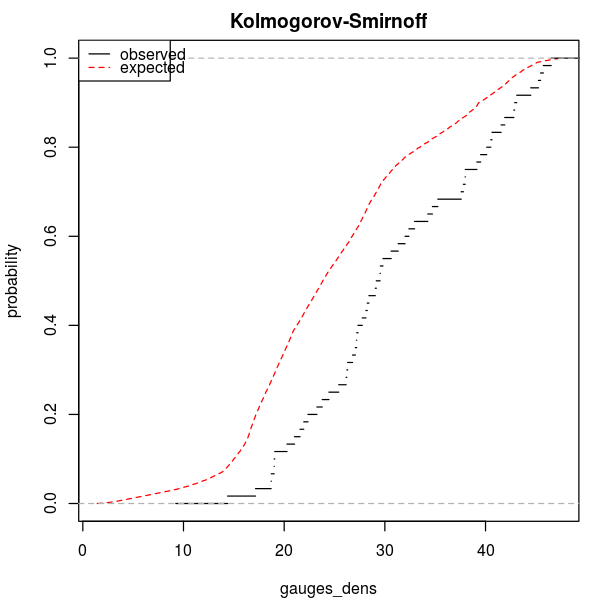

In [9]:
par(cex=0.8, mar=c(4,4,2,1)+0.1)
plot(gauges_ks, main="Kolmogorov-Smirnoff")

## Ripley's K
** Distance band chosen automatically in R **

$$\hat{K}(r) = \frac{1}{\lambda} * \sum_{i}\frac{I(d_{ij} < r)}{n}$$

$\lambda$ = average density

$d_{ij}$ = distance from point i to j

$r$ = bandwidth

$n$ = number of points


In [10]:
# Ripley's K test
gauges_fv <- Kest(gauges_ppp, correction=c("best"), var.approx=TRUE)

,lty,col,key,label,meaning
iso,1,1,iso,hat(K)[iso](r),isotropic-corrected estimate of K(r)
theo,2,2,theo,K[pois](r),theoretical Poisson K(r)


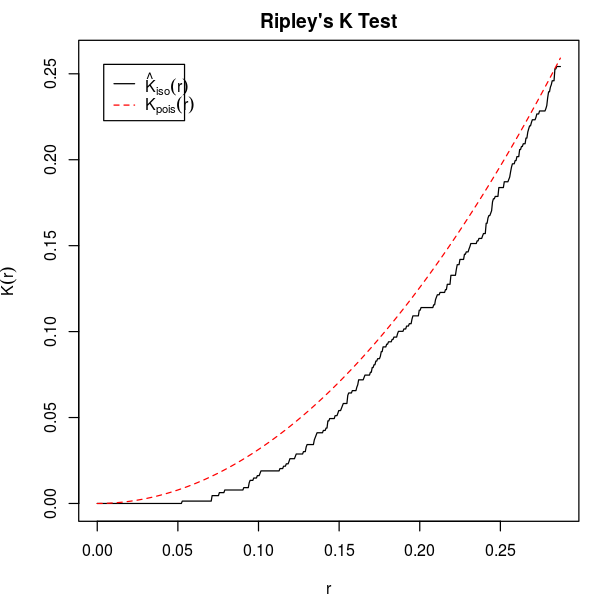

In [11]:
par(cex=0.8, mar=c(4,4,2,1)+0.1)
plot(gauges_fv, main="Ripley's K Test")

## Ripley's K with envelope

** using 49 simulations of complete spatial randomness **

Generating 49 simulations of CSR  ...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
46, 47, 48,  49.

Done.


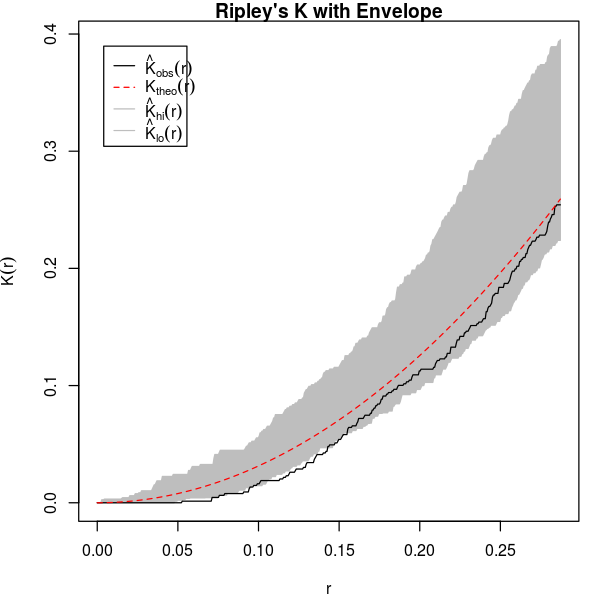

In [15]:
par(cex=0.8, mar=c(4,4,1,1)+0.1)
pl_RK <- plot(envelope(gauges_ppp, Kest, 49), 
              main="Ripley's K with Envelope")

## Ripley's L with envelope

$$ \hat{L}(r) = \sqrt{\frac{\hat{K}(r)}{\pi}}$$

** Theoretical distribution is straight line **

In [16]:
gauges_l <- Lest(gauges_ppp, correction="Ripley")
#plot(gauges_l, main="Ripley's L function")

Generating 49 simulations of CSR  ...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
46, 47, 48,  49.

Done.


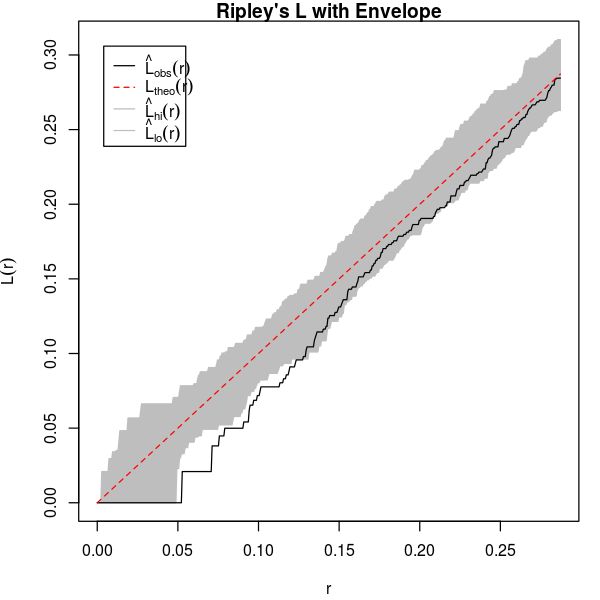

In [17]:
par(cex=0.8, mar=c(4,4,1,1)+0.1)
pl_RL <- plot(envelope(gauges_ppp, Lest, 49), 
              main="Ripley's L with Envelope")

## Conclusions
- Slightly dispersed, but nearly poisson at large distances
- Dispersed at short distances
- Mostly within the envelope, so close to Poisson from $0.15^o$ and up  